<a href="https://colab.research.google.com/github/ShriyaGandotra/Intro-to-Deep-Learning/blob/main/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Number of trainable parameters: 651978
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/20, Train Loss: 1.3814, Train Accuracy: 49.40%, Val Loss: 1.0892, Val Accuracy: 61.62%
Epoch 2/20, Train Loss: 0.9320, Train Accuracy: 67.29%, Val Loss: 0.8951, Val Accuracy: 68.18%
Epoch 3/20, Train Loss: 0.7414, Train Accuracy: 73.93%, Val Loss: 0.7861, Val Accuracy: 73.03%
Epoch 4/20, Train Loss: 0.6012, Train Accuracy: 78.76%, Val Loss: 0.7606, Val Accuracy: 74.78%
Epoch 5/20, Train Loss: 0.4969, Train Accuracy: 82.63%, Val Loss: 0.7846, Val Accuracy: 73.79%
Epoch 6/20, Train Loss: 0.4023, Train Accuracy: 85.82%, Val Loss: 0.7908, Val Accuracy: 75.10%
Epoch 7/20, Train Loss: 0.3308, Train Accuracy: 88.35%, Val Loss: 0.9051, Val Accuracy: 74.47%
Epoch 8/20, Train Loss: 0.2674, Train Accuracy: 90.51%, Val Loss: 0.9326, Val Accuracy: 74.75%
Epoch 9/20, Train Loss: 0.2223, Train Accuracy: 92.24%, Val Loss: 0.9910, Val Accuracy: 75.27%
Epoch 10/20, Train Loss: 0.191

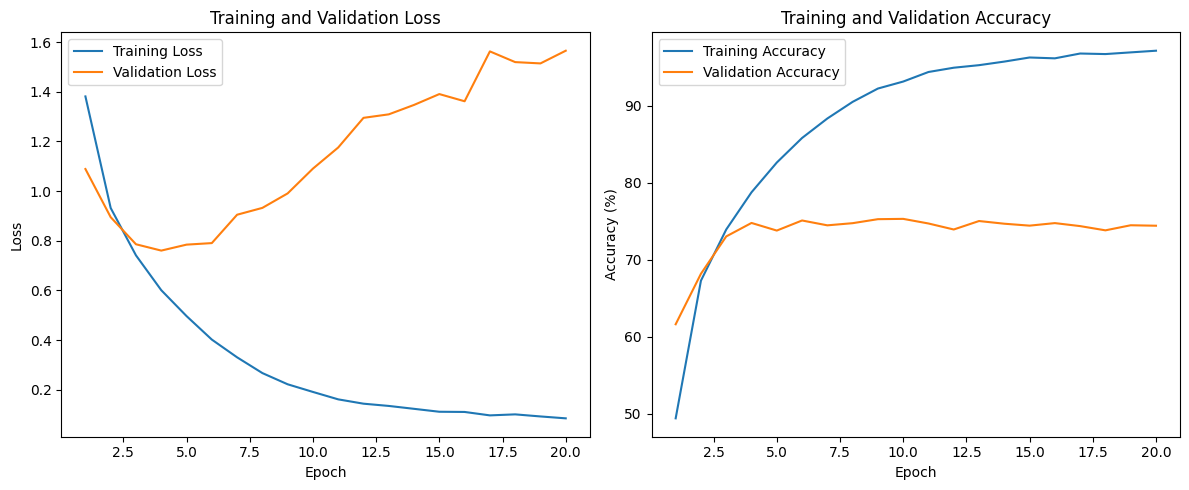

In [6]:
################### Problem 1 - AlexNet  ############################
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Check if CUDA is available and set device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # MaxPooling layer
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 256) # Adjust the input size according to your final feature map size
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
            # Convolutional layers with ReLU activations and MaxPooling
            x = F.relu(self.conv1(x))
            x = self.maxpool(x)

            x = F.relu(self.conv2(x))
            x = self.maxpool(x)

            x = F.relu(self.conv3(x))
            x = self.maxpool(x)

            # Flatten the output for the fully connected layer
            x = torch.flatten(x, 1)

            # Fully connected layers with ReLU activation for the first two
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))

            # Output layer with softmax is handled separately in PyTorch, typically with CrossEntropyLoss
            x = self.fc3(x)
            return x

# Initialize the model and send it to the device
model = AlexNet(num_classes=10).to(device)

# Count the number of trainable parameters
num_params = count_parameters(model)
print(f"Number of trainable parameters: {num_params}")

# Load and preprocess CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_accuracy)

    # Validation
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(test_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accs.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accs, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Number of trainable parameters: 651978
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/30, Train Loss: 1.5317, Train Accuracy: 43.86%, Val Loss: 1.1965, Val Accuracy: 56.92%
Epoch 2/30, Train Loss: 1.1948, Train Accuracy: 57.50%, Val Loss: 0.9932, Val Accuracy: 65.10%
Epoch 3/30, Train Loss: 1.0470, Train Accuracy: 63.44%, Val Loss: 0.8791, Val Accuracy: 69.15%
Epoch 4/30, Train Loss: 0.9564, Train Accuracy: 66.66%, Val Loss: 0.8495, Val Accuracy: 70.50%
Epoch 5/30, Train Loss: 0.9070, Train Accuracy: 68.57%, Val Loss: 0.8155, Val Accuracy: 71.92%
Epoch 6/30, Train Loss: 0.8579, Train Accuracy: 69.94%, Val Loss: 0.7485, Val Accuracy: 74.00%
Epoch 7/30, Train Loss: 0.8319, Train Accuracy: 71.23%, Val Loss: 0.7601, Val Accuracy: 73.72%
Epoch 8/30, Train Loss: 0.7988, Train Accuracy: 72.36%, Val Loss: 0.7406, Val Accuracy: 74.54%
Epoch 9/30, Train Loss: 0.7820, Train Accuracy: 72.99%, Val Loss: 0.7164, Val Accuracy: 75.45%
Epoch 10/30, Train Loss: 0.758

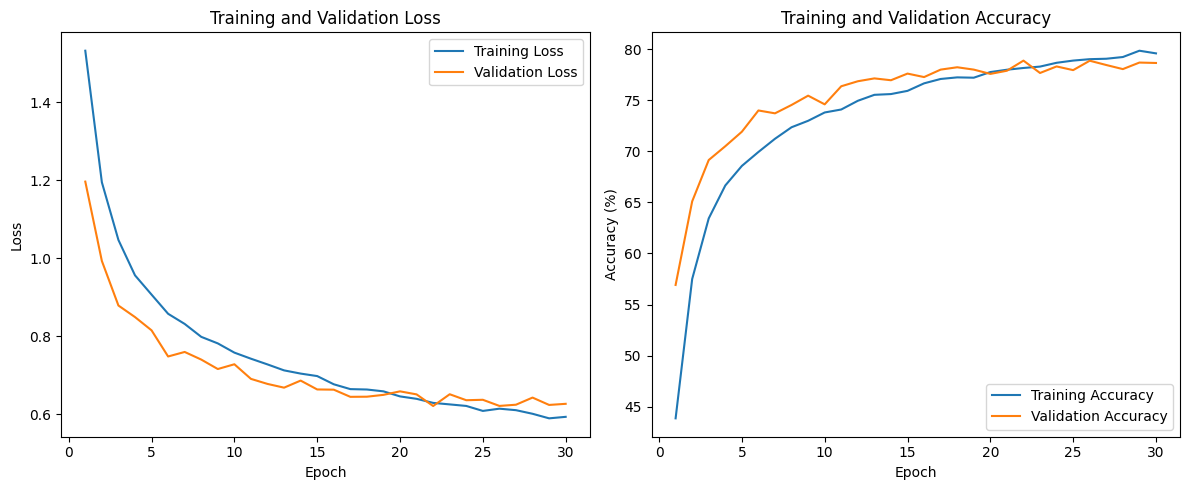

In [5]:
############# Problem 1 - AlexNet + Dropout ##########################
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Check if CUDA is available and set device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class AlexNet_Dropout(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet_Dropout, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # MaxPooling layer
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Dropout layer
        self.dropout = nn.Dropout(0.25)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 256) # Adjust the input size according to your final feature map size
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
            # Convolutional layers with ReLU activations and MaxPooling
            x = F.relu(self.conv1(x))
            x = self.maxpool(x)
            x = self.dropout(x)

            x = F.relu(self.conv2(x))
            x = self.maxpool(x)
            x = self.dropout(x)

            x = F.relu(self.conv3(x))
            x = self.maxpool(x)
            x = self.dropout(x)

            # Flatten the output for the fully connected layer
            x = torch.flatten(x, 1)

            # Fully connected layers with ReLU activation for the first two
            x = F.relu(self.fc1(x))
            x = self.dropout(x)
            x = F.relu(self.fc2(x))
            x = self.dropout(x)

            # Output layer with softmax is handled separately in PyTorch, typically with CrossEntropyLoss
            x = self.fc3(x)
            return x

# Initialize the model and send it to the device
model = AlexNet_Dropout(num_classes=10).to(device)

# Count the number of trainable parameters
num_params = count_parameters(model)
print(f"Number of trainable parameters: {num_params}")

# Load and preprocess CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_accuracy)

    # Validation
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(test_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accs.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accs, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/20, Train Loss: 1.3086, Train Accuracy: 52.57%, Val Loss: 0.9886, Val Accuracy: 65.03%
Epoch 2/20, Train Loss: 0.9373, Train Accuracy: 66.72%, Val Loss: 0.8846, Val Accuracy: 67.86%
Epoch 3/20, Train Loss: 0.7641, Train Accuracy: 73.28%, Val Loss: 0.8032, Val Accuracy: 71.48%
Epoch 4/20, Train Loss: 0.6319, Train Accuracy: 77.73%, Val Loss: 0.6754, Val Accuracy: 76.31%
Epoch 5/20, Train Loss: 0.5167, Train Accuracy: 82.15%, Val Loss: 0.6504, Val Accuracy: 77.65%
Epoch 6/20, Train Loss: 0.4108, Train Accuracy: 85.77%, Val Loss: 0.6969, Val Accuracy: 77.14%
Epoch 7/20, Train Loss: 0.3242, Train Accuracy: 88.91%, Val Loss: 0.7397, Val Accuracy: 76.42%
Epoch 8/20, Train Loss: 0.2368, Train Accuracy: 91.83%, Val Loss: 0.7260, Val Accuracy: 77.93%
Epoch 9/20, Train Loss: 0.1804, Train Accuracy: 93.80%, Val Loss: 0.7583, Val Accuracy: 78.31%
Epoch 10/20, Train Loss: 0.1386, Train Accuracy: 95.48%, Val Loss: 0.

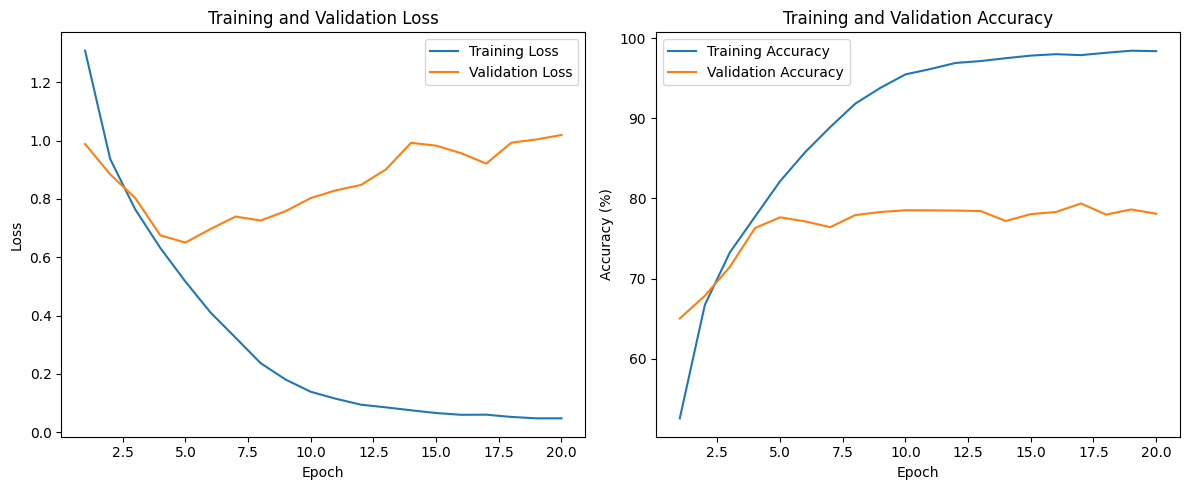

In [4]:
########################### Problem 2 - RESNET 11 ##############################
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


class ResNet11(nn.Module):
    def __init__(self):
        super(ResNet11, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(512)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 10)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.relu(self.bn5(self.conv5(x)))
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Prepare dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

# Instantiate the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ResNet11().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and Validation loop
num_epochs = 20
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_accuracy)

    # Validation
    model.eval()
    val_running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(test_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accs.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

# Plotting the training and validation results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accs, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/20, Train Loss: 1.3584, Train Accuracy: 50.44%, Val Loss: 1.0940, Val Accuracy: 60.74%
Epoch 2/20, Train Loss: 1.0196, Train Accuracy: 63.61%, Val Loss: 0.9288, Val Accuracy: 66.57%
Epoch 3/20, Train Loss: 0.8960, Train Accuracy: 68.09%, Val Loss: 0.7882, Val Accuracy: 72.14%
Epoch 4/20, Train Loss: 0.8099, Train Accuracy: 71.27%, Val Loss: 0.7464, Val Accuracy: 73.60%
Epoch 5/20, Train Loss: 0.7387, Train Accuracy: 74.03%, Val Loss: 0.6766, Val Accuracy: 75.83%
Epoch 6/20, Train Loss: 0.6768, Train Accuracy: 76.26%, Val Loss: 0.6563, Val Accuracy: 76.55%
Epoch 7/20, Train Loss: 0.6242, Train Accuracy: 77.93%, Val Loss: 0.6004, Val Accuracy: 79.13%
Epoch 8/20, Train Loss: 0.5789, Train Accuracy: 79.61%, Val Loss: 0.5898, Val Accuracy: 79.48%
Epoch 9/20, Train Loss: 0.5419, Train Accuracy: 80.87%, Val Loss: 0.5699, Val Accuracy: 80.61%
Epoch 10/20, Train Loss: 0.5039, Train Accuracy: 82.32%, Val Loss: 0.

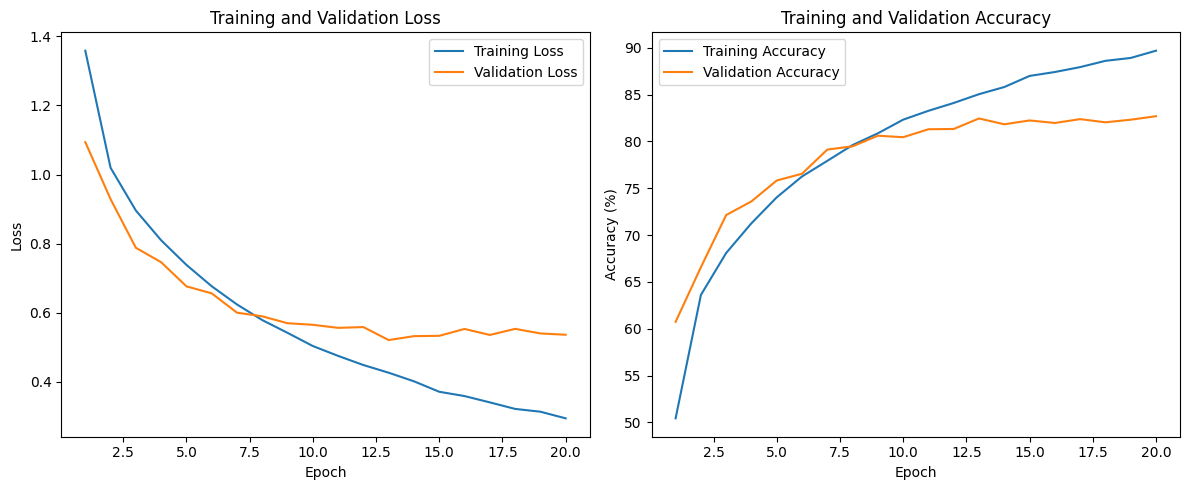

In [3]:
##################### Problem 2 - RESNET 11 + Dropout ##########################
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Resnet 11
class ResNet11_Dropout(nn.Module):
    def __init__(self, dropout_rate=0.25):
        super(ResNet11_Dropout, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout(dropout_rate)

        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout(dropout_rate)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.dropout4 = nn.Dropout(dropout_rate)

        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.dropout5 = nn.Dropout(dropout_rate)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 10)

    def forward(self, x):
        x = self.dropout1(self.relu(self.bn1(self.conv1(x))))
        x = self.dropout2(self.relu(self.bn2(self.conv2(x))))
        x = self.dropout3(self.relu(self.bn3(self.conv3(x))))
        x = self.dropout4(self.relu(self.bn4(self.conv4(x))))
        x = self.dropout5(self.relu(self.bn5(self.conv5(x))))
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Prepare dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

# Instantiate the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ResNet11_Dropout().to(device)


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and Validation loop
num_epochs = 20
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_accuracy)

    # Validation
    model.eval()
    val_running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(test_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accs.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

# Plotting the training and validation results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accs, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

100%|██████████| 170498071/170498071 [00:03<00:00, 43588364.98it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Number of trainable parameters: 1247530
Epoch 1/20, Train Loss: 1.2318, Train Accuracy: 55.48%, Val Loss: 1.0477, Val Accuracy: 63.39%
Epoch 2/20, Train Loss: 0.7882, Train Accuracy: 72.31%, Val Loss: 0.8221, Val Accuracy: 71.58%
Epoch 3/20, Train Loss: 0.6032, Train Accuracy: 79.03%, Val Loss: 0.6045, Val Accuracy: 78.58%
Epoch 4/20, Train Loss: 0.4826, Train Accuracy: 83.15%, Val Loss: 0.5547, Val Accuracy: 81.13%
Epoch 5/20, Train Loss: 0.3768, Train Accuracy: 86.77%, Val Loss: 0.5516, Val Accuracy: 81.76%
Epoch 6/20, Train Loss: 0.2890, Train Accuracy: 89.76%, Val Loss: 0.5809, Val Accuracy: 81.16%
Epoch 7/20, Train Loss: 0.2085, Train Accuracy: 92.59%, Val Loss: 0.6418, Val Accuracy: 80.76%
Epoch 8/20, Train Loss: 0.1579, Train Accuracy: 94.49%, Val Loss: 0.6960, Val Accuracy: 80.69%
Epoch 9/20, Train Loss: 0.1207, Train Accuracy: 95.78%, Val Loss: 0.6756, Val Accuracy: 81.97%
Epoch 10/20, Tra

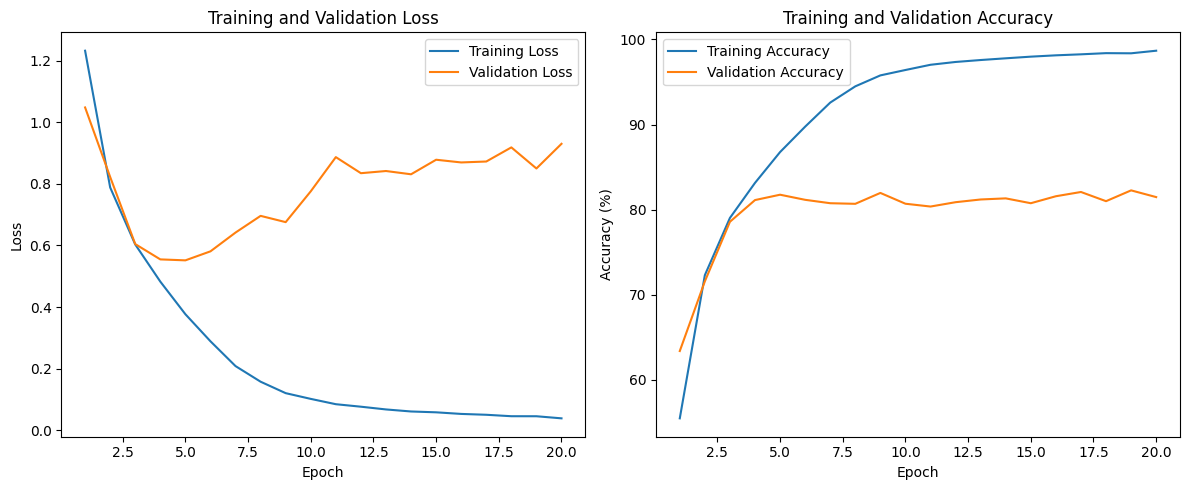

In [1]:
############################ Problem 2 - RESNET 18  ############################
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.optim as optim

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(identity)
        out = F.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet18, self).__init__()
        self.in_planes = 32
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Data Preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

# Instantiate the model without dropout
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ResNet18(BasicBlock, [2, 1, 1, 1]).to(device) # Adjusted the number of blocks to follow the original ResNet18 structure

# Count the number of trainable parameters
num_params = count_parameters(model)
print(f"Number of trainable parameters: {num_params}")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and Validation loop
num_epochs = 20
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_accuracy)

    # Validation
    model.eval()
    val_running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(test_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accs.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

# Plotting the training and validation results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accs, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Files already downloaded and verified
Files already downloaded and verified
Number of trainable parameters: 1247530
Epoch 1/20, Train Loss: 1.5658, Train Accuracy: 42.23%, Val Loss: 1.1356, Val Accuracy: 58.61%
Epoch 2/20, Train Loss: 1.1695, Train Accuracy: 57.91%, Val Loss: 0.9612, Val Accuracy: 65.16%
Epoch 3/20, Train Loss: 1.0034, Train Accuracy: 64.23%, Val Loss: 0.8809, Val Accuracy: 68.81%
Epoch 4/20, Train Loss: 0.9031, Train Accuracy: 68.06%, Val Loss: 0.7926, Val Accuracy: 71.77%
Epoch 5/20, Train Loss: 0.8212, Train Accuracy: 70.89%, Val Loss: 0.7354, Val Accuracy: 74.19%
Epoch 6/20, Train Loss: 0.7437, Train Accuracy: 74.16%, Val Loss: 0.6833, Val Accuracy: 76.74%
Epoch 7/20, Train Loss: 0.6830, Train Accuracy: 75.94%, Val Loss: 0.6354, Val Accuracy: 77.54%
Epoch 8/20, Train Loss: 0.6294, Train Accuracy: 77.89%, Val Loss: 0.6157, Val Accuracy: 78.54%
Epoch 9/20, Train Loss: 0.5858, Train Accuracy: 79.44%, Val Loss: 0.5917, Val Accuracy: 79.59%
Epoch 10/20, Train Loss: 0.55

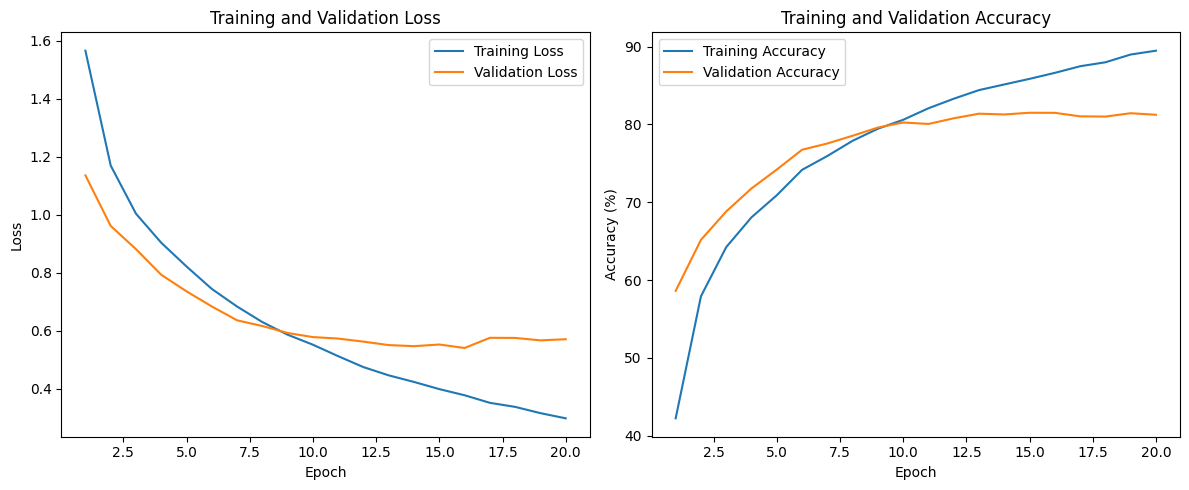

In [2]:
##################### Problem 2 - RESNET 18 + Dropout ##########################
import torch
import torch.nn as nn
import torch.nn.functional as F

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, dropout_rate=0.25):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.dropout1 = nn.Dropout2d(dropout_rate)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.dropout2 = nn.Dropout2d(dropout_rate)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout1(out)
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.dropout2(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10,dropout_rate=0.25):
        super(ResNet18, self).__init__()
        self.in_planes = 32

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# Data Preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

# Instantiate the model with dropout
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ResNet18(BasicBlock, [2, 1, 1, 1], dropout_rate=0.25).to(device)

# Count the number of trainable parameters
num_params = count_parameters(model)
print(f"Number of trainable parameters: {num_params}")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and Validation loop
num_epochs = 20
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_accuracy)

    # Validation
    model.eval()
    val_running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(test_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accs.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

# Plotting the training and validation results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accs, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()